In [1]:
import numpy as np 
import pandas as pd 
import scanpy as sc

/ix/djishnu/alw399/envs/otter/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ix/djishnu/alw399/envs/otter/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ix/djishnu/alw399/envs/otter/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ix/djishnu/alw399/envs/otter/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ix/djishnu/alw399/envs/otter/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `annda

In [1]:
import sys, os
sys.path.append('../../src')

from interaction import Interaction
from kmer import Kmerizer

In [3]:
# slide_outs = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+CD8/KIR+CD8_filtered85/KIR+CD8_filtered85_noint_output/0.1_1_out'
# slide_outs = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/KIR+TEDDY_filtered85/KIR+TEDDY_filtered85_noint_output/0.01_0.5_out'
slide_outs = '/ix/djishnu/alw399/SLIDE_SWING/slide-outputs/totalCD8_TEDDY_yKIR/CTL/0.1_1_out'

In [4]:
adata = sc.read_h5ad('/ix/djishnu/alw399/SLIDE_SWING/data/processed/totalCD8_TEDDY.h5ad')
adata = adata[adata.obs['clusters'] == 'CTL']
adata

View of AnnData object with n_obs × n_vars = 10242 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_Protein', 'nFeature_Protein', 'sample', 'percent.mt', 'cdr3_b', 'va_gene', 'ja_gene', 'cdr3_a', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'vb_gene', 'jb_gene', 'integrated_snn_res.0.25', 'cell_type', 'ID', 'timepoint', 'tp_indicator', 'tp_group', 'tp_single', 'group', 'KIR', 'source', 'clusters', 'count', 'expansion', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts'
    var: 'features', 'mt', 'ribo', 'hb', 'n_cell

In [5]:
mermaid = Kmerizer(k=2, token_size=4)
tcr_embeddings = mermaid.encode_batch(adata.obs['cdr3_b'].values)

tcr_embeddings.shape # (sample, tcr_length, embed_dim)

(10242, 26, 4)

In [6]:
# flatten because we use them as features

tcr_embeddings = tcr_embeddings.reshape(tcr_embeddings.shape[0], -1)
tcr_embeddings.shape

(10242, 104)

In [35]:
y = adata.obs['KIR'].copy()
y.replace({'KIR-': 0, 'KIR+': 1}, inplace=True)
y = y.values
y.shape

/tmp/ipykernel_48487/3373502041.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y.replace({'KIR-': 0, 'KIR+': 1}, inplace=True)
/tmp/ipykernel_48487/3373502041.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  y.replace({'KIR-': 0, 'KIR+': 1}, inplace=True)


(10242,)

In [8]:
machop = Interaction(slide_outs, plm_embed=tcr_embeddings, y=y)


In [9]:
beta_interaction = machop.compute(fdr=0.20)
beta_interaction.shape

/ix/djishnu/alw399/envs/otter/lib/python3.10/site-packages/knockpy/mrc.py:276: UserWarning: 
	---------------------------------------------------------
	---------------------------------------------------------
	The choldate package is not installed:
	solving for MVR or maxent knockoffs without it will be 
	~5x slower. For instructions on how to install choldate,
	see https://amspector100.github.io/knockpy/installation.html.
	To disable this warning, set choldate_warning=False as an 
	argument or a knockoff_kwarg.
	----------------------------------------------------------
	----------------------------------------------------------

  warnings.warn(constants.CHOLDATE_WARNING)


(3, 104)

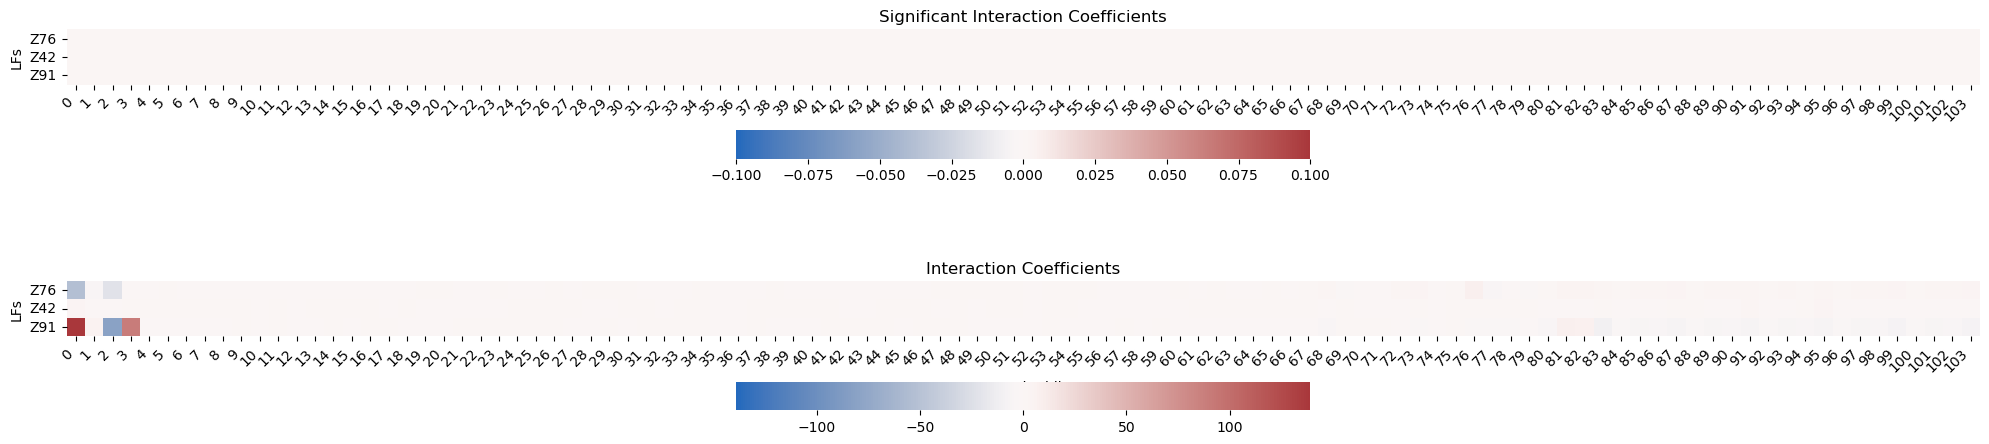

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

beta_interaction = machop.beta_interaction
sig_interaction = machop.sig_interaction

df = pd.DataFrame(beta_interaction, index=machop.sig_LFs, columns=range(machop.l))
max_beta = np.max(np.abs(beta_interaction))

df_sig = pd.DataFrame(sig_interaction, index=machop.sig_LFs, columns=range(machop.l))
max_sig = np.max(np.abs(sig_interaction))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6))

# Plot beta_interaction
sns.heatmap(data=df_sig, square=True, ax=ax1, vmin=-max_sig, vmax=max_sig, 
            cmap='vlag', cbar_kws={'orientation': 'horizontal', 'shrink': 0.3})
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set(ylabel='LFs', xlabel='PLM embedding', title='Significant Interaction Coefficients')

# Plot sig_interaction
sns.heatmap(data=df, square=True, ax=ax2, vmin=-max_beta, vmax=max_beta, 
            cmap='vlag', cbar_kws={'orientation': 'horizontal', 'shrink': 0.3})
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set(ylabel='LFs', xlabel='PLM embedding', title='Interaction Coefficients')

plt.tight_layout()


In [11]:
from deletion import EmbeddingEvaluator

evaluator = EmbeddingEvaluator()
accuracies = evaluator.get_contributions(
    embedding=machop.plm_embedding, 
    y=machop.y
)

ValueError: y must have at least two dimensions for multi-output regression but has only one.

In [ ]:
accuracies 

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

labels = ['baseline'] + list(range(machop.l))
sns.barplot(y=accuracies, x=labels, ax=ax, hue=labels, palette='viridis', legend=False)
ax.set_ylabel('Accuracy')
ax.set_xlabel('PLM embedding')

bars = ax.patches

for bar, accuracy in zip(bars,  accuracies):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{accuracy:.2f}',
        ha='center',
        va='bottom'
    )
ax.set_title('Accuracy when PLM embedding dimension is removed')
ax.set_ylim(np.min(accuracies) - 0.01, np.max(accuracies) + 0.01)

plt.tight_layout()
plt.show()

In [ ]:
# first col is standalone
max = np.max(np.abs(machop.beta_all))

fig, ax = plt.subplots()
sns.heatmap(machop.beta_all, square=True, ax=ax, vmin=-max, vmax=max, 
             
            cmap='vlag', cbar_kws={'orientation': 'horizontal', 'shrink': 0.5})
_ = ax.set(ylabel='LFs', xlabel='PLM embedding', title='Interaction coefficients')

In [ ]:
correlation_matrix = np.corrcoef(machop.z_matrix.T, machop.plm_embedding.T)
sns.heatmap(correlation_matrix)